In [237]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split 

from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
from sklearn.metrics import accuracy_score, roc_auc_score, PrecisionRecallDisplay, RocCurveDisplay, precision_score, recall_score, make_scorer
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_validate, TunedThresholdClassifierCV, FixedThresholdClassifier

import optuna
from plotly.io import show


from IPython.display import display_html, display

In [238]:
pos_label, neg_label = 1, 0

def fpr_score(y, y_pred, neg_label, pos_label):
    cm = confusion_matrix(y, y_pred, labels=[neg_label, pos_label])
    tn, fp, _, _ = cm.ravel()
    tnr = tn / (tn + fp)
    return 1 - tnr

tpr_score = recall_score  # TPR and recall are the same metric
scoring = {
    "precision": make_scorer(precision_score, pos_label=pos_label),
    "recall": make_scorer(recall_score, pos_label=pos_label),
    "fpr": make_scorer(fpr_score, neg_label=neg_label, pos_label=pos_label),
    "tpr": make_scorer(tpr_score, pos_label=pos_label),
}

scoring

{'precision': make_scorer(precision_score, response_method='predict', pos_label=1),
 'recall': make_scorer(recall_score, response_method='predict', pos_label=1),
 'fpr': make_scorer(fpr_score, response_method='predict', neg_label=0, pos_label=1),
 'tpr': make_scorer(recall_score, response_method='predict', pos_label=1)}

In [239]:
train = pd.read_csv('dataset_citrus/train.csv')
test = pd.read_csv('dataset_citrus/test.csv')
y_true = pd.read_csv('dataset_citrus/test_Y_true.csv')

train['name'] = np.where(train['name']=='grapefruit',0,1)
y_true = np.where(y_true =='grapefruit',0,1).reshape(-1)
train.head()

,name,diameter,weight,red,green,blue
0,0,11.60,199.71,153,59,16
1,0,10.25,178.06,148,54,14
2,0,11.99,205.39,133,72,2
3,1,7.63,139.91,152,82,2
4,1,7.43,137.10,158,78,3


In [240]:
X, y = train.drop(['name'],axis=1), train['name']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [107]:
def objective(trial):
    # Препроцессинг
    ## Список скалеров в препроцессинге
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard', 'robust', 'normalizer', 'none'])

    ## Определение скалеров
    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()
    elif scalers == "robust":
        scaler = RobustScaler()
    elif scalers == "normalizer":
        scaler = Normalizer()
    else:
        scaler = 'passthrough'

    # Определяем модель машинного обучения
    ## количество соседей
    knn_n_neighbors=trial.suggest_int("knn_n_neighbors", 60, 120, step=1) 
    ## степень метрики миньковского
    knn_p = trial.suggest_int("knn_p", 1, 10, step=1)
    ## влияние растояния
    knn_weights=trial.suggest_categorical("knn_weights", ['uniform', 'distance'])

    estimator=KNeighborsClassifier(n_neighbors=knn_n_neighbors, p = knn_p, weights=knn_weights)

    # Собираем контейнер
    pipeline = make_pipeline(scaler, estimator)

    # Вычисляем средний результат на кроссвалидации
    cv_score = cross_val_score(pipeline, X, y, cv=7, scoring='roc_auc')
    score_mean = cv_score.mean()
    return score_mean
    
study = optuna.create_study(direction = "maximize") 
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2025-02-19 16:49:13,031] A new study created in memory with name: no-name-589854f6-5bf3-42d8-b354-ca9401f0be8f


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-02-19 16:49:13,601] Trial 0 finished with value: 0.9783285316599455 and parameters: {'scalers': 'normalizer', 'knn_n_neighbors': 90, 'knn_p': 8, 'knn_weights': 'distance'}. Best is trial 0 with value: 0.9783285316599455.
[I 2025-02-19 16:49:14,411] Trial 1 finished with value: 0.9799202084549652 and parameters: {'scalers': 'robust', 'knn_n_neighbors': 87, 'knn_p': 10, 'knn_weights': 'distance'}. Best is trial 1 with value: 0.9799202084549652.
[I 2025-02-19 16:49:15,363] Trial 2 finished with value: 0.9803681036733912 and parameters: {'scalers': 'robust', 'knn_n_neighbors': 102, 'knn_p': 3, 'knn_weights': 'distance'}. Best is trial 2 with value: 0.9803681036733912.
[I 2025-02-19 16:49:16,225] Trial 3 finished with value: 0.9786908538815099 and parameters: {'scalers': 'none', 'knn_n_neighbors': 79, 'knn_p': 2, 'knn_weights': 'uniform'}. Best is trial 2 with value: 0.9803681036733912.
[I 2025-02-19 16:49:17,585] Trial 4 finished with value: 0.9796603080114838 and parameters: {'sca

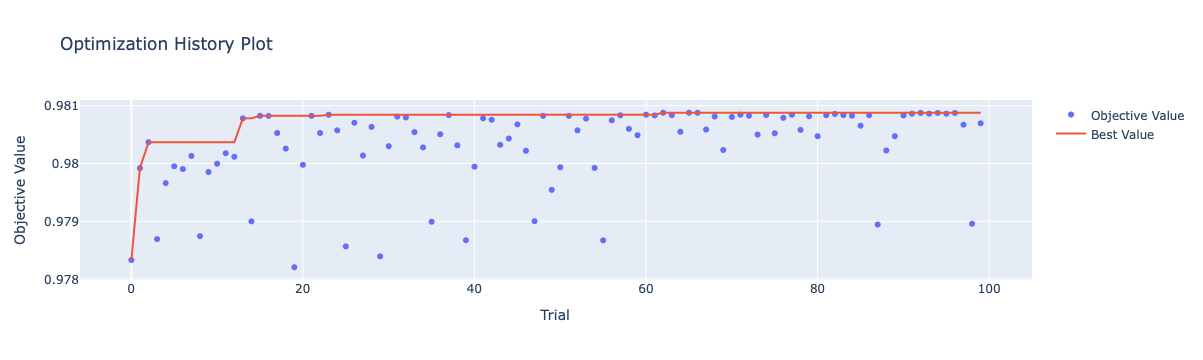

In [108]:
optuna.visualization.plot_optimization_history(study)

In [109]:
study.best_trial.params

{'scalers': 'standard',
 'knn_n_neighbors': 97,
 'knn_p': 1,
 'knn_weights': 'distance'}

In [110]:
model = make_pipeline(RobustScaler(), KNeighborsClassifier(n_neighbors=114, p = 1, weights='distance'))
model.fit(X_train,y_train)


Pipeline(steps=[('robustscaler', RobustScaler()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=114, p=1,
                                      weights='distance'))])

In [111]:
y_train_predict_proba = model.predict_proba(X_train)
y_test_proba = model.predict_proba(X_test)
y_predict = model.predict(X_test)

In [112]:
print('train: ', roc_auc_score(y_train, y_train_predict_proba[:, 1]))
print('test : ', roc_auc_score(y_test, y_test_proba[:, 1]))

train:  1.0
test :  0.9846101137765718


In [113]:
pd.DataFrame(classification_report(y_test, y_predict, output_dict=True)).T

,precision,recall,f1-score,support
0,0.932018,0.924918,0.928454,919.000000
1,0.928349,0.935146,0.931735,956.000000
accuracy,0.930133,0.930133,0.930133,0.930133
macro avg,0.930183,0.930032,0.930095,1875.000000
weighted avg,0.930147,0.930133,0.930127,1875.000000


In [247]:
score = "accuracy"
cv = RepeatedStratifiedKFold(n_splits=7, n_repeats = 7)
cv_ths = TunedThresholdClassifierCV(estimator = model, scoring=score, cv=cv).fit(X_train, y_train)
cv_ths.best_threshold_

0.5858585858585859

In [248]:
model_final = FixedThresholdClassifier(model, threshold = 0.5858585858585859).fit(X_train, y_train)

In [249]:
yf_train_predict_proba = model_final.predict_proba(X_train)
yf_test_proba = model_final.predict_proba(X_test)
yf_predict = model_final.predict(X_test)

In [250]:
df1 = pd.DataFrame(classification_report(y_test, y_predict, output_dict=True)).T
df2 = pd.DataFrame(classification_report(y_test, yf_predict, output_dict=True)).T

df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption('origin')
df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption('thresholds')

display_html(df1_styler._repr_html_() + df2_styler._repr_html_(), raw=True)

,precision,recall,f1-score,support
0,0.932018,0.924918,0.928454,919.000000
1,0.928349,0.935146,0.931735,956.000000
accuracy,0.930133,0.930133,0.930133,0.930133
macro avg,0.930183,0.930032,0.930095,1875.000000
weighted avg,0.930147,0.930133,0.930127,1875.000000
,precision,recall,f1-score,support
0,0.916930,0.948857,0.932620,919.000000
1,0.949134,0.917364,0.932979,956.000000
accuracy,0.932800,0.932800,0.932800,0.932800
macro avg,0.933032,0.933111,0.932800,1875.000000


In [251]:
def plot_roc_pr_curves(vanilla_model, tuned_model, cv_model, *, title):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(21, 6))
    
    linestyles = ("dashed", "dotted")
    markerstyles = ("o", ">")
    colors = ("tab:blue", "tab:orange")
    names = ("Vanilla model", "Tuned model")
    for idx, (est, linestyle, marker, color, name) in enumerate(
        zip((vanilla_model, tuned_model), linestyles, markerstyles, colors, names)
    ):
        decision_threshold = getattr(est, "best_threshold_", 0.5)
        PrecisionRecallDisplay.from_estimator(
            est,
            X_test,
            y_test,
            pos_label=pos_label,
            linestyle=linestyle,
            color=color,
            ax=axs[0],
            name=name,
        )
        axs[0].plot(
            scoring["recall"](est, X_test, y_test),
            scoring["precision"](est, X_test, y_test),
            marker,
            markersize=10,
            color=color,
            label=f"Cut-off point at probability of {decision_threshold:.2f}",
        )
        RocCurveDisplay.from_estimator(
            est,
            X_test,
            y_test,
            pos_label=pos_label,
            linestyle=linestyle,
            color=color,
            ax=axs[1],
            name=name,
            plot_chance_level=idx == 1,
        )
        axs[1].plot(
            scoring["fpr"](est, X_test, y_test),
            scoring["tpr"](est, X_test, y_test),
            marker,
            markersize=10,
            color=color,
            label=f"Cut-off point at probability of {decision_threshold:.2f}",
        )

    axs[0].set_title("Precision-Recall curve")
    axs[0].legend()
    axs[1].set_title("ROC curve")
    axs[1].legend()

    axs[2].plot(
        cv_model.cv_results_["thresholds"],
        cv_model.cv_results_["scores"],
        color="tab:orange",
    )
    axs[2].plot(
        cv_model.best_threshold_,
        cv_model.best_score_,
        "o",
        markersize=10,
        color="tab:orange",
        label="Optimal cut-off point for the business metric",
    )
    axs[2].legend()
    axs[2].set_xlabel("Decision threshold (probability)")
    axs[2].set_ylabel("Objective score (using cost-matrix)")
    axs[2].set_title("Objective score as a function of the decision threshold")
    fig.suptitle(title)


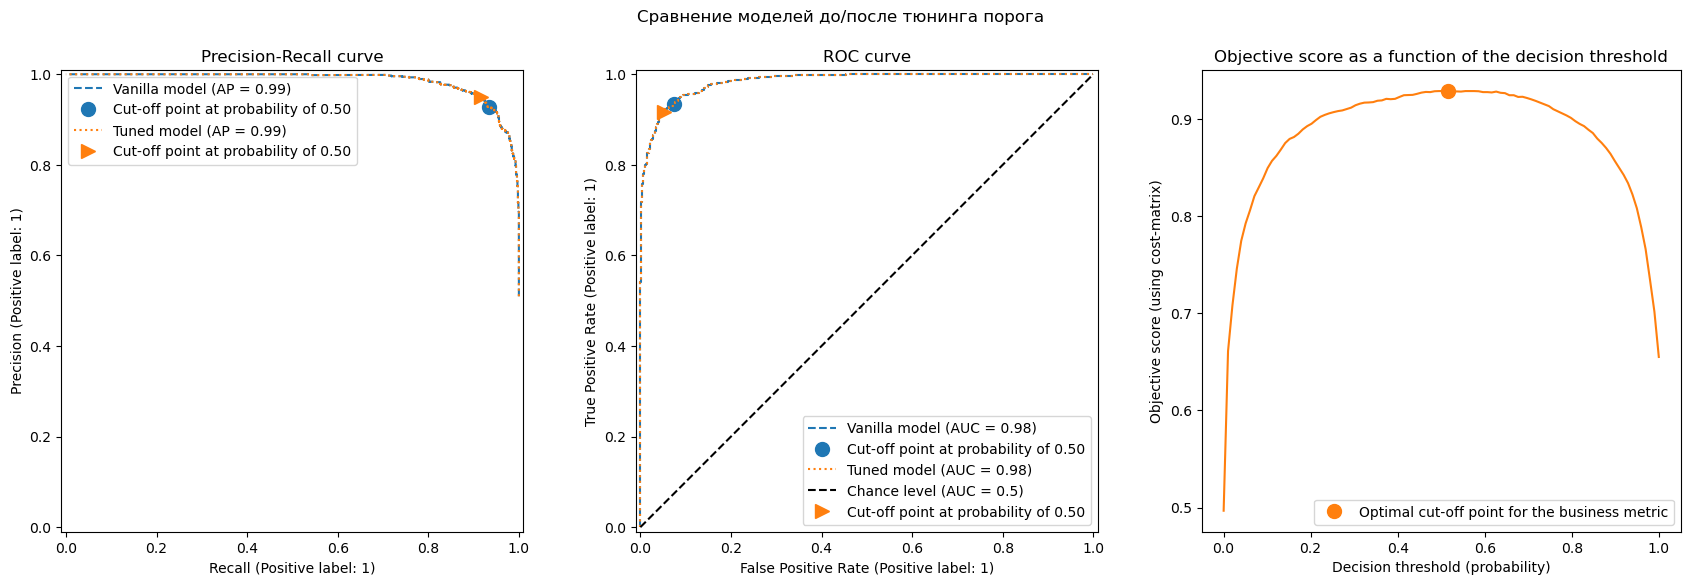

In [252]:
title = "Сравнение моделей до/после тюнинга порога"
cv_ths = TunedThresholdClassifierCV(estimator = model, scoring=score, store_cv_results=True, cv=7).fit(X_train,y_train)
plot_roc_pr_curves(model, model_final, cv_ths, title=title)